In [113]:
from stochsearch import EvolSearch
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [135]:
# our custom ctrnn
class CTRNN:

    def __init__(self,size=2,step_size=0.1):
        '''
        Constructer that initializes a random network
        with unit time-constants and biases
        ARGS:
        size: integer = network size
        step_size:float = euler integration step size
        '''
        self.size = size
        self.step_size = step_size
        self.taus = np.ones(size)
        self.biases = np.ones(size)
        self.gains = np.ones(size)
        self.weights = csr_matrix(np.random.rand(size,size))
        self.states = np.random.rand(size)
        self.outputs = self.sigmoid(self.states)
        self.sound_output = np.ones(1)

    @property
    def taus(self): return self.__taus

    @property
    def biases(self): return self.__biases

    @property
    def gains(self): return self.__gains

    @property
    def states(self): return self.__states

    @property
    def outputs(self): return self.__outputs

    @property
    def sound_output(self): return self.__sound_output


    @taus.setter
    def taus(self,ts):
        '''
        Set time-constants
        args = ts:array[size,] = time-constant for each neuron
        '''
        if len(ts) != self.size:
            raise Exception("Size mismatch error - len(taus) != network_size")
        
        # prevent division by zero
        epsilon = 1e-6
        ts[0] = ts[0] + epsilon
        ts[1] = ts[1] + epsilon
        self.__taus = np.asarray(ts)

    @biases.setter
    def biases(self,bis):
        '''
        Set biases
        args = bis:array[size,] = bias for each neuron
        '''
        if len(bis) != self.size:
            raise Exception("Size mismatch - len(biases) != network_size")
        self.__biases = np.asarray(bis)

    @gains.setter
    def gains(self,gs):
        '''
        Set gains
        args = gs:array[size,] = gain for each neuron
        '''
        if len(gs) != self.size:
            raise Exception("Size mismatch - len(gains) != network_size")
        self.__gains = np.asarray(gs)

    @states.setter
    def states(self,s):
        '''
        Set states
        args = s:array[size,] = state for each neuron
        '''
        if len(s) != self.size:
            raise Exception("Size mismatch - len(states) != network_size")
        self.__states = np.asarray(s)
        self.__outputs = self.sigmoid(s)

    @outputs.setter
    def outputs(self,o):
        '''
        Set outputs
        args = o:array[size,] = output for each neuron
        '''
        if len(o) != self.size:
            raise Exception("Size mismatch - len(outputs) != network_size")
        self.__outputs = np.asarray(o)
        self.__states = self.inverse_sigmoid(o)/self.gains - self.biases

    @sound_output.setter
    def sound_output(self,o):
        '''
        Set sound outputs
        args = o:array[size,] = output for neuron
        '''
        self.__sound_output = np.asarray(o)
        

    def randomize_states(self,lb,ub):
        '''
        Randomize states in range [lb,ub]
        args = lb:float = lower bound for random range
                ub:float = upper bound for random range
        '''
        self.states = np.random.uniform(lb,ub,size=(self.size))

    def randomize_outputs(self,lb,ub):
        '''
        Randomize outputs in range [lb,ub]
        args = lb:float = lower bound for random range
                ub:float = upper bound for random range
        '''
        self.outputs = np.random.uniform(lb,ub,size=(self.size))

    def euler_step(self,external_inputs):
        '''
        Euler stepping the network by self.step_size with provided inputs
        args = external_inputs:array[size,] = one float input per neuron
        '''
        if len(external_inputs) != self.size:
            raise Exception("Size mismatch - len(external_inputs) != network_size")
        external_inputs = np.asarray(external_inputs)
        total_inputs = external_inputs + self.weights.dot(self.outputs)
        self.states += self.step_size*(1/self.taus)* (total_inputs - self.states)
        self.outputs = self.sigmoid(self.gains*(self.states + self.biases))

        # how do we want to calculate sound output? a + b or a - b or a/b
        self.sound_output = self.sigmoid(self.states[0] / self.states[1])

    def sigmoid(self,s):
        '''
        Computes the sigmoid function on input array
        args = s:array of any Size
        output = sigmoid(s):array of same size as input
        '''
        return 1/(1+np.exp(-s))

    def inverse_sigmoid(self,o):
        '''
        Computes the inverse of the sigmoid function
        args = o:array of any size
        returns = inverse_sigmoid(o):array same size as o
        '''

        inverse_sig = np.log(o/(1-o))
        #inverse_sig[np.isinf(inverse_sig)] = 0.
        return inverse_sig

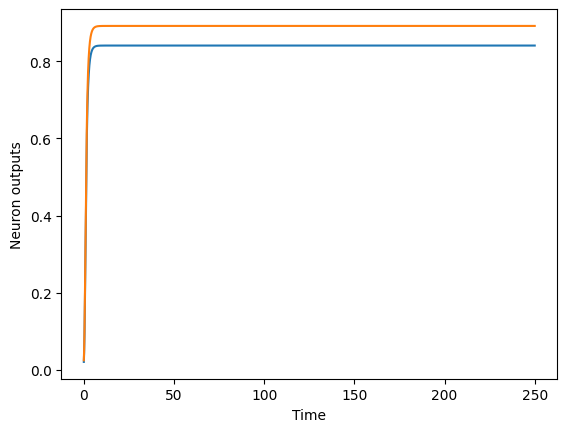

In [142]:
# trial run for webot

# params
run_duration = 250
net_size = 2
step_size = 0.01

network_0_states = []
network_1_states = []

random_preset_sound_level = [0.5]

# set up both network
network_0 = CTRNN(size=net_size,step_size=step_size)
network_1 = CTRNN(size=net_size,step_size=step_size)

# initialize network 
network_0.randomize_outputs(0.0,0.1)    #TODO should this be range 0,1?
network_1.randomize_outputs(0.0,0.1)

# simulate network
outputs_0 = []
outputs_1 = []

for _ in range(int(run_duration/step_size)):
    # TODO read sound input for both CTRNN from WeBot
    # sound_input needs to be taken from webot, updated after every time step 
    # set bot positions on 2d grid 
    # calculate input from preset level and distance
    sound_input_0 = [0.1, 0.12]
    sound_input_1 = [0.1, 0.09]
    
    network_0.euler_step(sound_input_0) 
    network_1.euler_step(sound_input_1) 

    step_motor_output_0 = [network_0.outputs[i] for i in range(net_size)]
    step_motor_output_1 = [network_1.outputs[i] for i in range(net_size)]

    outputs_0.append(step_motor_output_0)
    outputs_1.append(step_motor_output_1)

    network_0_states.append(network_0.states.mean())
    network_1_states.append(network_1.states.mean())

    # TODO send both to WeBots
    step_motor_output_0
    step_motor_output_1


# reshape to array
outputs_0 = np.asarray(outputs_0)
outputs_1 = np.asarray(outputs_1)

mean_0 = sum(network_0_states) / len(network_0_states)
mean_1 = sum(network_1_states) / len(network_1_states)

avg_mean = (mean_0 + mean_1) / 2


# plot oscillator output
plt.plot(np.arange(0,run_duration,step_size),outputs_0[:,0])
plt.plot(np.arange(0,run_duration,step_size),outputs_1[:,1])
plt.xlabel('Time')
plt.ylabel('Neuron outputs')
plt.show()

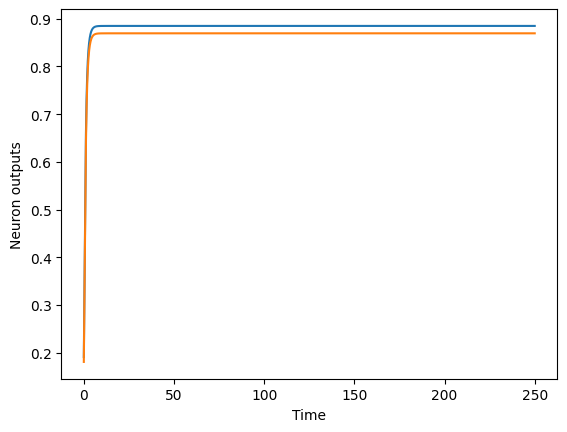

In [102]:
# full eval function for robotic interaction
# run with evolsearch
# args are used to randomize input for robots and find parameters with highest activation

def fitness_function(args):
    # params
    run_duration = 250
    net_size = 2
    step_size = 0.01

    network_0_states = []
    network_1_states = []


    # set up network
    network_0 = CTRNN(size=net_size,step_size=step_size)
    network_0.taus = args[0:2]
    network_0.biases = args[2:4]
    network_0.weights[0,0] = args[4]
    network_0.weights[0,1] = args[5]
    network_0.weights[1,0] = args[6]
    network_0.weights[1,1] = args[7]

    # TODO setup second CTRNN
    network_1 = CTRNN(size=net_size,step_size=step_size)
    network_1.taus = args[8:10]
    network_1.biases = args[10:12]
    network_1.weights[0,0] = args[12]
    network_1.weights[0,1] = args[13]
    network_1.weights[1,0] = args[14]
    network_1.weights[1,1] = args[15]

    # initialize network
    network_0.randomize_outputs(0.0,1.0)
    network_1.randomize_outputs(0.0,1.0)

    # simulate network
    outputs_0 = []
    outputs_1 = []

    for _ in range(int(run_duration/step_size)):
        # TODO read sound input for both CTRNN from WeBot
        sound_input_0 = [0.1, 0.12]
        sound_input_1 = [0.1, 0.09]
        
        network_0.euler_step(sound_input_0) 
        network_1.euler_step(sound_input_1) 

        step_motor_output_0 = [network_0.outputs[i] for i in range(net_size)]
        step_motor_output_1 = [network_1.outputs[i] for i in range(net_size)]

        outputs_0.append(step_motor_output_0)
        outputs_1.append(step_motor_output_1)

        network_0_states.append(network_0.states.mean())
        network_1_states.append(network_1.states.mean())

        # TODO send both to WeBots
        step_motor_output_0
        step_motor_output_1

    # reshape to array
    outputs_0 = np.asarray(outputs_0)
    outputs_1 = np.asarray(outputs_1)

    mean_0 = sum(network_0_states) / len(network_0_states)
    mean_1 = sum(network_1_states) / len(network_1_states)

    avg_mean = (mean_0 + mean_1) / 2

    return avg_mean

# Search

In [108]:
evol_params = {
    'num_processes' : 8, # (optional) number of proccesses for multiprocessing.Pool
    'pop_size' : 8,    # population size
    'genotype_size': 16, # dimensionality of solution
    'fitness_function': fitness_function, # custom function defined to evaluate fitness of a solution
    'elitist_fraction': 0.04, # fraction of population retained as is between generations
    'mutation_variance': 0.05, # mutation noise added to offspring.
    'fitness_args': np.arange(1), # (optional) fitness_function *argv, len(list) should be 1 or pop_size  # TODO what should this be?
}

In [109]:
# trial run for parameters
es = EvolSearch(evol_params)

# just iterate
num_gens = 2
es.execute_search(num_gens)
es.get_best_individual()

array([0.73053771, 0.8606332 , 0.78556257, 0.07177965, 0.75066745,
       0.48302345, 0.90665941, 0.05116422, 0.81277043, 0.93227847,
       0.48276642, 0.17943184, 0.76305731, 0.88714417, 0.37986662,
       0.79389095])

In [91]:
class robot_parameters:
    def __init__(self, parameters):

        if len(parameters) != 16:
            raise ValueError("Expected 16 parameters, got {}".format(len(parameters)))

        self.taus_a = parameters[0:2]
        self.biases_a = parameters[2:4]
        self.weights_a = parameters[4:8]
               
        self.taus_b = parameters[8:10]
        self.biases_b = parameters[10:13]
        self.weights_b = parameters[13:16]

In [111]:
# trial run for full evaluation

num_gens = 2                 # should be 500 for full run
best_robots_list = []

for i in range(2):           # should be 100 for full run
    es.execute_search(num_gens)
    parameters = es.get_best_individual()
    robots = robot_parameters(parameters)
    best_robots_list.append(robots)
